In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Fri Aug 20 15:03:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.9 MB/s 
     |████████████████████████████████| 895 kB 54.1 MB/s 
     |████████████████████████████████| 636 kB 74.2 MB/s 
     |████████████████████████████████| 3.3 MB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 916 kB 8.9 MB/s 
     |████████████████████████████████| 118 kB 70.5 MB/s 
     |████████████████████████████████| 272 kB 90.7 MB/s 
     |████████████████████████████████| 829 kB 84.5 MB/s 
     |████████████████████████████████| 1.3 MB 50.8 MB/s 
     |████████████████████████████████| 294 kB 65.3 MB/s 
     |████████████████████████████████| 142 kB 78.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=035a4f4c1acbc3209f796720626837763ae68220f960de8988d376a99a6b5a2f
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/train.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Coronavirus disease 2019 COVID-19 caused Sever...,0,0,0,0,1,0,0
1,COVID-19 pandemic created unusually challengin...,0,0,0,0,1,0,0
2,BACKGROUND Respiratory complication well remar...,0,0,0,0,0,0,1
3,outbreak severe pneumonia unknown cause report...,0,0,0,0,1,1,1
4,Robust testing tracing key fighting menace cor...,0,0,0,0,1,0,0


In [ ]:
# preprocess dataset
# df = df.drop(['pmid',	'journal',	'title', 'doi',	'label', 'keywords', 'pub_type', 'authors'], axis=1)
# df.head()
# drop none value
train_df = train_df.dropna()
train_df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Coronavirus disease 2019 COVID-19 caused Sever...,0,0,0,0,1,0,0
1,COVID-19 pandemic created unusually challengin...,0,0,0,0,1,0,0
2,BACKGROUND Respiratory complication well remar...,0,0,0,0,0,0,1
3,outbreak severe pneumonia unknown cause report...,0,0,0,0,1,1,1
4,Robust testing tracing key fighting menace cor...,0,0,0,0,1,0,0


In [ ]:
LABEL_COLUMNS = train_df.columns.tolist()[1:]

In [ ]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: dmis-lab/biobert-base-cased-v1.1


Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
val_df = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/dev.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.dropna()
val_df.shape

(3119, 8)

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[5.454903677758319, 1.7826584632994706, 16.545816733067728, 2.52104411169567, 1.0, 10.178921568627452, 1.2688664833486099]


In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 5.454903677758319,
 'Diagnosis': 1.7826584632994706,
 'Epidemic Forecasting': 16.545816733067728,
 'Mechanism': 2.52104411169567,
 'Prevention': 1.0,
 'Transmission': 10.178921568627452,
 'Treatment': 1.2688664833486099}

In [ ]:
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)

    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, input_ids, attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # last_hidden_state (batch_size x sequence_length x hidden_size)
    encoded_output = bert_outputs.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(encoded_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))

    # output = self.classifier(output.pooler_output)
    # output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3508, 17540)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'

/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="biobert-lwan-checkpoints",
    filename="biobert-lwan-best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("biobert-lwan-lightning_logs", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | criterion  | BCELoss   | 0     
2 | fc         | Linear    | 5.4 K 
3 | relu       | ReLU      | 0     
4 | softmax    | Softmax   | 0     
5 | classifier | Line

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 1754: val_loss reached 0.51875 (best 0.51875), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/biobert-lwan-checkpoints/biobert-lwan-best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3509: val_loss reached 0.50111 (best 0.50111), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/biobert-lwan-checkpoints/biobert-lwan-best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 5264: val_loss reached 0.42827 (best 0.42827), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/biobert-lwan-checkpoints/biobert-lwan-best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 7019: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 8774: val_loss was not in top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


### Test

In [ ]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/biobert-lwan-checkpoints/biobert-lwan-best-checkpoint.ckpt', n_classes=7)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trained_model.freeze()

### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)    
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3119 [00:00<?, ?it/s]

#### Accuracy

In [ ]:
THRESHOLD = 0.9

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9406)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9894294142723083
Diagnosis: 0.9665996432304382
Epidemic Forecasting: 0.9928610324859619
Mechanism: 0.9805675745010376
Prevention: 0.9823628664016724
Transmission: 0.976233720779419
Treatment: 0.9743515253067017


#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report       0.95      0.69      0.80       261
           Diagnosis       0.96      0.55      0.70       750
Epidemic Forecasting       0.95      0.45      0.61        84
           Mechanism       0.92      0.69      0.79       568
          Prevention       0.97      0.88      0.92      1390
        Transmission       0.82      0.48      0.61       120
           Treatment       0.95      0.75      0.84      1104

           micro avg       0.95      0.73      0.83      4277
           macro avg       0.93      0.64      0.75      4277
        weighted avg       0.95      0.73      0.82      4277
         samples avg       0.85      0.78      0.80      4277



In [ ]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [ ]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [ ]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

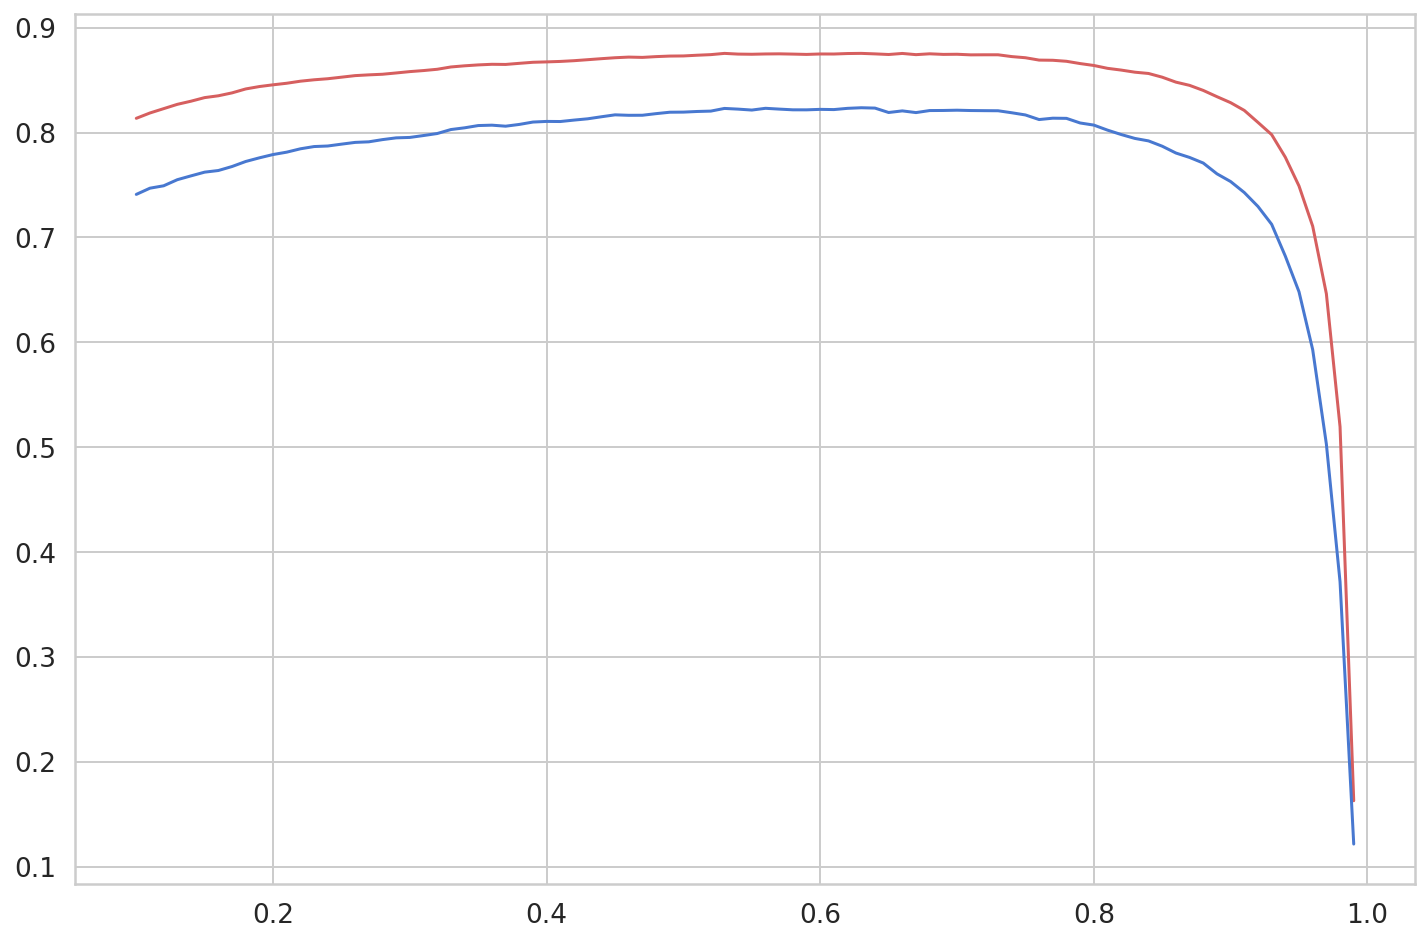

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [ ]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[53]

(0.875514282355707, 53, 0.63)